# Hřebenová regrese, vztah vychýlení a rozptylu

V tomto notebooku se budeme zabývat hřebenovou regresí a analýzou vztahu vychýlení a rozptylu

In [15]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation (so 0.000 is printed as 0.)

## Načtení dat

Využijeme opět data o cenách domů v oblasti Bostonu v USA, která máme uložená v souboru `data.csv`.

Data jsou již vyčištěná. Proměnná, kterou chceme predikovat je `medv`.

In [16]:
df = pd.read_csv('data.csv').astype('float64')
print('Shape', df.shape)
df.head()

Shape (333, 15)


,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1.0,0.00632,18.0,2.31,0.0,5.38,65.75,65.2,4.0900,1.0,29.6,15.3,39.690,4.98,24.0
1,2.0,0.02731,0.0,7.07,0.0,4.69,64.21,78.9,4.9671,2.0,24.2,17.8,39.690,9.14,21.6
2,4.0,0.03237,0.0,2.18,0.0,4.58,69.98,45.8,6.0622,3.0,22.2,18.7,39.463,2.94,33.4
3,5.0,0.06905,0.0,2.18,0.0,4.58,71.47,54.2,6.0622,3.0,22.2,18.7,39.690,5.33,36.2
4,7.0,0.08829,12.5,7.87,0.0,5.24,60.12,66.6,5.5605,5.0,31.1,15.2,39.560,12.43,22.9


### Příprava trénovací a testovací množiny

Využijeme [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) ze `scikit-learn`.

In [69]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(df.drop(columns = ['ID', 'medv']), df['medv'], test_size=0.25, random_state=42)
print('Train X shape', X.shape)
print('Test X shape', X_test.shape)

Train X shape (249, 13)
Test X shape (84, 13)


#### Vytvoříme model lineární regrese pro porovnání

[-0.07709  0.05966 -0.01475  0.41967 -1.68647  0.3559  -0.01256 -1.81433
  0.40758 -0.15644 -0.77078  0.07523 -0.58124]
RMSE: 4.799532488947327


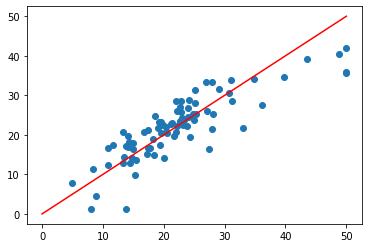

In [70]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X,Y)

print(clf.coef_)

Yth = clf.predict(X_test)
plt.scatter(Y_test, Yth)
plt.plot([0,50], [0,50], 'r')

print('RMSE:', np.sqrt(mean_squared_error(Yth, np.array(Y_test))))

## Task 1 - použijte model hřebenové regrese

* Zopakujte postup z předchozího bodu s využitím třídy [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) ze `scikit-learn`.
* Nejprve zkuste různé hodnoty $\lambda$ (zde parametr `alpha`).
* Poté zkuste automatický výběr hodnoty $\lambda$ s využitím `scipy.optimize.minimize_scalar` a `sklearn.model_selection.cross_val_score`
* Výsledné RMSE pro testovací data porovnejte s výstupem lineární regrese.

[-0.07674  0.05956 -0.01541  0.4191  -1.6594   0.35619 -0.01266 -1.80436
  0.40722 -0.15686 -0.76706  0.07527 -0.58169]
RMSE: 4.798536061288684


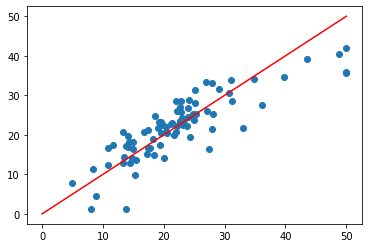

In [71]:
# Your code here
from sklearn.linear_model import Ridge

clf = Ridge()
clf.fit(X,Y)

print(clf.coef_)

Yth = clf.predict(X_test)
plt.scatter(Y_test, Yth)
plt.plot([0,50], [0,50], 'r')

print('RMSE:', np.sqrt(mean_squared_error(Yth, np.array(Y_test))))

In [72]:
from scipy.optimize import minimize_scalar

def ridge(alpha, X=X, Y=Y, X_test=X_test):
    clf = Ridge(alpha=alpha)
    clf.fit(X, Y)
    y_hat = clf.predict(X_test)
    return np.sqrt(mean_squared_error(y_hat, np.array(Y_test)))

optimal_alpha = minimize_scalar(ridge, bounds=(0,200), method='bounded' ).x

In [73]:
from sklearn.model_selection import cross_val_score

def ridgeCV(alpha):
    model = Ridge(alpha=alpha)
    return np.mean(np.sqrt(-cross_val_score( model, X, Y, cv=7, scoring='neg_mean_squared_error' )))

optimal_alpha = minimize_scalar(ridgeCV, bounds=(0,200), method='bounded' ).x
print(optimal_alpha)
print("RMSE:", ridge(optimal_alpha))

11.620813219539832
RMSE: 4.791018990888485


## Task 2 - zopakujte předchozí úlohu pro standardizované příznaky
* Ke standardizaci využijte `sklearn.preprocessing.StandardScaler`.
* Výsledné RMSE pro testovací data porovnejte s výstupem lineární regrese a předchozí hřebenové regrese.

In [74]:
# Your code here
from sklearn.preprocessing import StandardScaler

def optimize(x=X, y=Y):
    return minimize_scalar(ridgeCV, bounds=(0,200), method='bounded').x

scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
Xs_test = scaler.transform(X_test)

l = optimize(Xs, Y)
print("opt lambda: ", l)
print("RMSE:", ridge(l, Xs, Y, Xs_test))


opt lambda:  11.620813219539832
RMSE: 4.69580353277368


## Task 3 - na umělých datech numericky prozkoumejte vztah vychýlení a rozptylu
Nejprve si připravíme funkce na náhodný výběr z modelu

X shape: (50, 4)


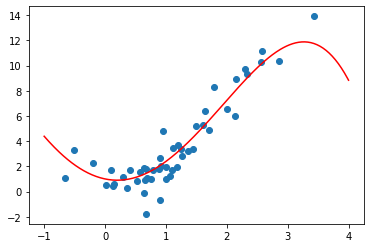

In [22]:
np.random.seed(5)  # zajistí replikovatelnost
x = np.random.randn(50) + 1
x_plot = np.linspace(-1,4,300)

def getX(x, max_degree = 5):
    X = x.reshape(-1,1)
    for i in range(2, max_degree):
        X = np.concatenate((X, (x**i).reshape(-1,1)), axis = 1)
    return X

X = getX(x)
X_plot = getX(x_plot)
print('X shape:', X.shape)

# funkce, která vrací náhodný výběr z těch dat
def getY(X, random = True):
    # vytvoření skutečného w
    w = np.concatenate((np.array([1,-1,2.5,0,-0.11,0]), np.zeros(1000)),)
    w = w[0:(X.shape[1]+1)]
    # přidání interceptu
    Xx = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X), axis = 1)
    # reset random seedu aby to bylo náhodné
    np.random.seed()
    # nagenerujeme z modelu trénovací množiny
    EY = Xx.dot(w)
    if random:
        return EY + np.random.randn(X.shape[0])*1
    else:
        return EY

# vezmeme si jeden trénovací dataset
Y = getY(X)
# zobrazíme ho
plt.scatter(x,Y)

# vyrobíme si skutečné střední hodnoty
EY_plot = getY(X_plot, random = False)
plt.plot(x_plot,EY_plot, 'r')

#### Proveďte predikci pomocí hřebenové regrese
Zafixujte $\lambda$ (alpha) a 100x proveďte:
* Nagenerování trénovacích hodnot $Y$.
* Predikci pomocí hřebenové regrese pro testovací hodnoty `X_plot`.

Výslednou predikci, tj. křivku dvojic `(x_plot, Yhat_plot)`, vykreslete do jednoho grafu spolu se výběrovým průměrem přes všechny predikce.

Diskutujte jak se výsledky mění v závislosti se zvyšujícím $\lambda$.

In [ ]:
# můžete použít standardizaci
from sklearn.preprocessing import StandardScaler
# v takovém případě zkuste využít pipelines
from sklearn.pipeline import make_pipeline

# pipe = make_pipeline(StandardScaler(), Ridge(alpha = 0)) 
pipe = make_pipeline(Ridge(alpha = 0))


# your code here
